<a href="https://colab.research.google.com/github/kamnsv/datawagon2/blob/main/DataWagon_2_3_WagonWizards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Окружение

In [2]:
#@title Импорт библиотек
import os
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from typing import Tuple, Union
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten, LSTM, Conv1D
from tensorflow.keras.layers import Flatten, Reshape, MaxPool1D,  MaxPooling1D, Concatenate
from tensorflow.keras.layers import Input,  concatenate, Reshape, Masking
from tensorflow.keras import utils, regularizers, constraints
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import utils

# Датасет

## Вывод статистики

In [ ]:
 def table_state(name):
        print(name)
        data = pd.read_parquet('data' + os.sep + 'train_1'+ os.sep + f'{name}.parquet').convert_dtypes()
        inf=("Фича", "тип", "Пустых","НЕпустые", "Уникальных", "min", "max", "Пример")
        table = pd.DataFrame(columns=inf)
        count = len(data)
        for i, col in enumerate(data):
          na = data[col].isna().sum() # кол-во пустых
          name = f'{i+1} {col}, {data[col].dtypes}'      # единицы из группы
          row = {
                "Фича":        col,
                "тип":         data[col].dtypes,
                "Пустых":      na,
                "НЕпустые":    count - na,
                "Уникальных":  data[col].nunique(),
                "min":         '' if 'object' ==  data[col].dtypes else data[col].min(),
                "max":         '' if 'object' ==  data[col].dtypes else data[col].max(),
                "Пример":      data[col].unique()[:5],
          }
          table = pd.concat([table, pd.DataFrame([row])], ignore_index=True)
        pd.set_option('display.max_rows',  count)
        return table, data

In [ ]:
#@title Информация по дислокации
table, dislok_wagons = table_state('dislok_wagons')
table

dislok_wagons


C:\Users\user\AppData\Local\Temp\ipykernel_16392\105451595.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame([row])], ignore_index=True)


,Фича,тип,Пустых,НЕпустые,Уникальных,min,max,Пример
0,plan_date,datetime64[us],0,6250933,184,2022-08-01 00:00:00,2023-01-31 00:00:00,"[2022-08-01 00:00:00, 2022-08-02 00:00:00, 202..."
1,wagnum,Int64,0,6250933,33977,0,33976,"[1071, 1072, 834, 835, 3205]"
2,date_kap,datetime64[us],2755031,3495902,4322,2005-04-07 00:00:00,2022-08-14 00:00:00,"[NaT, 2020-06-29 00:00:00, 2022-03-16 00:00:00..."
3,date_dep,datetime64[us],351873,5899060,2047,2013-07-20 00:00:00,2022-08-14 00:00:00,"[2020-02-16 00:00:00, 2019-12-29 00:00:00, 202..."
4,kod_vrab,Int64,0,6250933,3,0,2,"[0, 1, 2]"
5,date_pl_rem,datetime64[us],0,6250933,1376,2016-06-01 00:00:00,2026-12-14 00:00:00,"[2023-02-16 00:00:00, 2022-12-29 00:00:00, 202..."
6,id_road_disl,Int64,0,6250933,32,0,45,"[42, 0, 29, 25, 26]"
7,st_id_dest,Int64,0,6250933,2448,0,16011,"[22, 11663, 11666, 11470, 15788]"
8,id_road_dest,Int64,0,6250933,32,0,45,"[42, 0, 26, 25, 30]"
9,st_id_send,Int64,0,6250933,2559,3,16011,"[11470, 11661, 11662, 11666, 12604]"


In [ ]:
#@title Справочник грузов
table, freight_info = table_state('freight_info')
table

freight_info


,Фича,тип,Пустых,НЕпустые,Уникальных,min,max,Пример
0,fr_id,Int64,0,5079,5079,1,5086,"[4989, 4990, 4991, 4992, 4993]"
1,fr_class,Int64,0,5079,4,0,3,"[2, 0, 1, 3]"
2,skoroport,Int64,0,5079,2,0,1,"[0, 1]"
3,naval,Int64,0,5079,2,0,1,"[0, 1]"
4,nasip,Int64,0,5079,2,0,1,"[0, 1]"
5,naliv,Int64,0,5079,2,0,1,"[0, 1]"
6,openvagons,Int64,0,5079,2,0,1,"[0, 1]"
7,soprovod,Int64,0,5079,2,0,1,"[0, 1]"
8,smerz,Int64,0,5079,2,0,1,"[0, 1]"


In [ ]:
#@title Данные по КТИ
table, kti_izm = table_state('kti_izm')
table

kti_izm


,Фича,тип,Пустых,НЕпустые,Уникальных,min,max,Пример
0,wagnum,Int64,0,22428,6686,0,33975,"[1302, 1374, 2916, 3849, 4494]"
1,operation_date_dttm,object,0,22428,28,,,"[2023-02-17, 2023-02-25, 2023-02-21, 2023-02-1..."
2,mileage_all,Int64,273,22155,20053,1,497856,"[67638, 83798, 121660, 59664, 7306]"
3,axl1_l_w_flange,Float64,12,22416,103,23.5,34.0,"[29.6, 29.1, 30.4, 30.6, 30.9]"
4,axl1_r_w_flange,Float64,19,22409,105,23.4,34.0,"[29.5, 27.9, 26.5, 29.2, 28.7]"
5,axl2_l_w_flange,Float64,16,22412,103,23.7,34.0,"[30.0, 27.7, 30.8, 31.6, 32.4]"
6,axl2_r_w_flange,Float64,20,22408,102,23.8,34.0,"[29.6, 29.1, 28.2, 28.5, 28.1]"
7,axl3_l_w_flange,Float64,17,22411,102,23.9,34.0,"[30.2, 29.3, 26.9, 31.0, 31.2]"
8,axl3_r_w_flange,Float64,21,22407,105,21.8,34.0,"[29.9, 30.2, 27.1, 30.7, 29.7]"
9,axl4_l_w_flange,Float64,15,22413,105,23.4,33.9,"[30.9, 29.4, 29.8, 29.3, 30.5]"


In [ ]:
#@title Плановый ремонт
table, pr_rems = table_state('pr_rems')
table

pr_rems


,Фича,тип,Пустых,НЕпустые,Уникальных,min,max,Пример
0,wagnum,Int64,0,10441,10393,12,33976,"[15000, 25485, 25944, 24080, 28612]"
1,rem_month,datetime64[us],0,10441,183,2022-08-02 00:00:00,2023-01-31 00:00:00,"[2022-08-05 00:00:00, 2022-08-21 00:00:00, 202..."
2,rod_id,Int64,0,10441,2,0,1,"[1, 0]"
3,model,string[python],0,10441,39,11-1807,12-9850-02,"[12-132, 12-132-03, 12-296-01, 12-1303-01, 11-..."
4,road_id_send,Int64,0,10441,18,3,47,"[3, 13, 6, 19, 5]"
5,road_id_rem,Int64,0,10441,18,3,47,"[3, 13, 7, 6, 19]"
6,kod_vrab,Int64,0,10441,2,0,1,"[0, 1]"
7,st_id_send,Int64,0,10441,911,23,16008,"[493, 6152, 4711, 4799, 5919]"
8,st_id_rem,Int64,0,10441,415,23,13043,"[493, 4793, 3940, 420, 10375]"
9,distance,Int64,0,10441,2028,0,6642,"[37, 360, 322, 308, 373]"


In [ ]:
#@title Справочник станций
table, stations = table_state('stations')
table

stations


,Фича,тип,Пустых,НЕпустые,Уникальных,min,max,Пример
0,st_id,Int64,0,148032,16160,23,16700,"[13069, 9353, 9973, 13745, 14554]"
1,road_id,Int64,0,148032,23,3,52,"[47, 18, 19, 6, 15]"
2,st_border_sign,string[python],0,148032,2,0,1,"[0, 1]"
3,st_sea_sign,string[python],0,148032,2,0,1,"[0, 1]"
4,st_river_sign,string[python],0,148032,2,0,1,"[0, 1]"
5,st_car_sign,string[python],0,148032,2,0,1,"[0, 1]"
6,st_ferry_sign,string[python],0,148032,2,0,1,"[0, 1]"
7,st_freigh_sign,string[python],0,148032,2,0,1,"[0, 1]"
8,opor_station_sign,string[python],0,148032,2,0,1,"[0, 1]"


In [ ]:
#@title Текущий ремонт
table, tr_rems = table_state('tr_rems')
table

tr_rems


,Фича,тип,Пустых,НЕпустые,Уникальных,min,max,Пример
0,wagnum,Int64,0,48652,17849,0,33976,"[29938, 29852, 13674, 1145, 2430]"
1,rem_month,datetime64[us],0,48652,6,2022-08-01 00:00:00,2023-01-01 00:00:00,"[2022-08-01 00:00:00, 2022-09-01 00:00:00, 202..."
2,kod_vrab,Int64,0,48652,3,2,5,"[3, 2, 5]"
3,neis1_kod,Int64,0,48652,120,0,132,"[0, 14, 36, 95, 2]"
4,neis2_kod,Int64,0,48652,88,0,98,"[98, 97, 95, 62, 2]"
5,neis3_kod,Int64,0,48652,45,0,54,"[54, 51, 0, 52, 13]"
6,mod1_kod,Int64,0,48652,8,0,7,"[7, 4, 1, 6, 2]"
7,mod2_kod,Int64,0,48652,5,0,4,"[4, 3, 1, 0, 2]"
8,mod3_kod,Int64,0,48652,3,0,2,"[2, 1, 0]"
9,mod4_kod,Int32,0,48652,1,0,0,[0]


In [ ]:
#@title Остаточный пробег
table, wagons_probeg_ownersip = table_state('wagons_probeg_ownersip')
table

wagons_probeg_ownersip


C:\Users\user\AppData\Local\Temp\ipykernel_16392\105451595.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame([row])], ignore_index=True)


,Фича,тип,Пустых,НЕпустые,Уникальных,min,max,Пример
0,repdate,datetime64[us],0,6249857,184,2022-08-01 00:00:00,2023-01-31 00:00:00,"[2022-08-01 00:00:00, 2022-08-02 00:00:00, 202..."
1,wagnum,Int64,0,6249857,33977,0,33976,"[33361, 33364, 33366, 33358, 33349]"
2,ost_prob,Int64,256959,5992898,241360,-48906,500000,"[7541, 7243, 6990, 6347, 6027]"
3,manage_type,Int64,0,6249857,2,0,1,"[0, 1]"
4,rod_id,Int64,0,6249857,2,0,1,"[1, 0]"
5,reestr_state,Int64,0,6249857,3,0,2,"[1, 2, 0]"
6,ownership_type,Int64,0,6249857,1,0,0,[0]
7,month,Int64,0,6249857,6,1,12,"[8, 9, 10, 11, 12]"


In [ ]:
#@title Параметры вагонов
table, wag_params = table_state('wag_params')
table

wag_params


,Фича,тип,Пустых,НЕпустые,Уникальных,min,max,Пример
0,wagnum,Int64,0,33977,33977,0,33976,"[26318, 28344, 8099, 33350, 5308]"
1,model,string[python],0,33977,50,11-066-04,Р-9494-01,"[12-600-04, 12-132, 11-286, 12-9850-02, 11-276]"
2,rod_id,Int64,0,33977,2,0,1,"[1, 0]"
3,gruz,Int64,0,33977,17,660,750,"[682, 700, 670, 750, 680]"
4,cnsi_gruz_capacity,Int64,0,33977,17,660,750,"[682, 700, 670, 750, 680]"
5,cnsi_volumek,Float64,0,33977,22,73.0,174.0,"[85.0, 88.0, 138.0, 90.0, 122.0]"
6,tara,Int64,0,33977,56,217,273,"[240, 270, 248, 260, 250]"
7,date_build,datetime64[ms],0,33977,8637,1985-04-12 00:00:00,2024-11-29 00:00:00,"[1992-12-25 00:00:00, 2003-08-12 00:00:00, 199..."
8,srok_sl,datetime64[ms],0,33977,9119,2017-12-11 00:00:00,2056-11-20 00:00:00,"[2022-04-27 00:00:00, 2024-12-24 00:00:00, 202..."
9,zavod_build,Int64,0,33977,24,0,23,"[5, 0, 1, 19, 17]"


##  Формирование

In [121]:
#@title Нормализация данных
class Datanorm:
  def __init__(self, paths: list,
               name=None, ohe: list=None, fk: list=None, cls: dict=None):

    self.paths = paths
    self.ohe = ohe if ohe else [] # поля для унарного кодирования
    self.scalers = {}   # Обученные скейлеры для обратной трансформации
    self.fk = fk if fk else [] # внешнии ключи (их не нормализуют)
    self.cls = cls if cls else {}  # параметр чистки, нет поля удалить, 0 - занулить, 1 - среднее
    self.df = self.load(name) if name else None

  def load(self, name): # метод загрузки данных

      df = pd.read_parquet(self.paths[0] + f'{os.sep}{name}.parquet').convert_dtypes()
      for path in self.paths[1:]:
        print(name)
        print(df.shape)
        print(pd.read_parquet(path + f'{os.sep}{name}.parquet').convert_dtypes().shape)

        df = pd.concat([df, pd.read_parquet(path + f'{os.sep}{name}.parquet').convert_dtypes()], axis=0)

      self.state = self.table_state(df)
      df = self.clears(df)
      df = self.scales(df)
      df = self.coders(df)
      assert self.table_state(df)['Пустых'].sum()==0, 'Есит пустые данные'
      return df

  def clears(self, df): # Чистка данных

    if self.cls:
      for k, v in self.cls.items():
        mean = df[k].mean() if v else self.zero(df[k])
        df[k].fillna(mean, inplace=True)

    df.dropna(inplace=True)

    return df

  def zero(self, ser: pd.Series):
    if self.is_time_field(ser):
      return np.datetime64('1970-01-01T00:00:00')

    if 'str' in str(ser.dtype).lower():
      return ''

    return 0

  def coders(self, df):  # Унарное кодирование
    if self.ohe:
      return pd.get_dummies(df, columns=self.ohe)
    return df

  def is_time_field(self, ser: pd.Series):
      dtype = str(ser.dtypes).lower()
      return 'date' in dtype or 'time' in dtype

  def scales(self, df): # Скалирование данных
    scale = set(df.columns).difference(set(self.ohe))
    self.scale = set(scale).difference(set(self.fk))

    for k in self.scale:

      if self.is_time_field(df[k]):
        df[k] = pd.to_datetime(df[k])
        continue
      if 'object' == str(df[k].dtypes).lower():
        try:
          df[k] = pd.to_datetime(df[k])
          continue
        except: pass

      scaler = MinMaxScaler()
      try:
        df[k] = scaler.fit_transform(df[[k]])
        self.scalers[k] = {'min': scaler.data_min_[0], 'scaler': scaler,
                         'max': scaler.data_max_[0]}
      except Exception as e:
        print(k, 'не скалиррован, тип:', df[k].dtype, e)

    return df

  @staticmethod
  def table_state(data):
          inf=("Фича", "тип", "Пустых","НЕпустые", "Уникальных", "min", "max", "Пример")
          table = pd.DataFrame(columns=inf)
          count = len(data)
          for i, col in enumerate(data):
            na = data[col].isna().sum() # кол-во пустых
            name = f'{i+1} {col}, {data[col].dtypes}'      # единицы из группы
            row = {
                  "Фича":        col,
                  "тип":         data[col].dtypes,
                  "Пустых":      na,
                  "НЕпустые":    count - na,
                  "Уникальных":  data[col].nunique(),
                  "min":         '' if 'object' ==  data[col].dtypes else data[col].min(),
                  "max":         '' if 'object' ==  data[col].dtypes else data[col].max(),
                  "Пример":      data[col].unique()[:5],
            }
            table = pd.concat([table, pd.DataFrame([row])], ignore_index=True)
          pd.set_option('display.max_rows',  count)
          return table

In [122]:
#@title Класс датасета

class Dataset:

  def __init__(self, path: list, target: list):

    # таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
    self.target = pd.read_csv(target[0]).convert_dtypes()
    for p in target[1:]:
        self.target = pd.concat([self.target, pd.read_csv(p).convert_dtypes()], axis=0)

    self.target.month = pd.to_datetime(self.target.month)



    # параметры вагона
    self.wag_param = Datanorm(path[:1], 'wag_params',
                    ohe=['ownertype', 'model', 'rod_id', 'zavod_build', 'kuzov','telega','tormoz','tipvozd','tippogl','norma_km'],
                    cls={'date_iskl': 0, 'tippogl': 0},
                    fk=['wagnum'])

    self.wag_param.df = self.wag_param.df.drop_duplicates(subset='wagnum', keep='last')

    # данные по дислокации
    self.dislok = Datanorm(path, 'dislok_wagons',
                    ohe=['kod_vrab', 'id_road_disl', 'id_road_dest'],
                    cls={'date_kap': 0, 'date_dep': 0},
                    fk=['wagnum','st_id_dest','st_id_send','fr_id','last_fr_id'])

    # данные по плановым ремонтам
    self.pr_rem = Datanorm(path, 'pr_rems',
                    ohe='rod_id,model,road_id_send,road_id_rem,kod_vrab,month'.split(','),
                    fk=['wagnum', 'st_id_send', 'st_id_rem'])

    # список вагонов с остаточным пробегом на момент прогноза
    self.wag_prob = Datanorm(path, 'wagons_probeg_ownersip',
                    ohe='manage_type,rod_id,reestr_state,ownership_type'.split(','),
                    fk=['wagnum'])

    # текущие ремонты вагонов
    self.tr_rem = Datanorm(path, 'tr_rems',
                    ohe=['kod_vrab','road_id_send'] + [f'neis{i}_kod' for i in range(1,4)] + [f'mod{i}_kod' for i in range(1,8)],
                    cls={'gr_probeg': 0, 'por_probeg': 0},
                    fk=['wagnum', 'st_id_send'])

    # данные по КТИ
    self.kti_izm = Datanorm(path[:1], 'kti_izm', fk=['wagnum', 'st_id_send'])

    # справочник грузов
    self.freight = Datanorm(path[:1], 'freight_info',
                    ohe='fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz'.split(','),
                    fk=['fr_id'])

    # справочник станций
    self.stations = Datanorm(path[:1], 'stations',
                    ohe='road_id,st_border_sign,st_sea_sign,st_river_sign,st_car_sign,st_ferry_sign,st_freigh_sign,opor_station_sign'.split(','),
                    fk=['st_id'])

In [123]:
#@title Загрузка данных
path_train = 'data' + os.sep + 'train_1'
path_test = 'data' + os.sep + 'train_2'
path_train_y = path_train + os.sep + 'target' + os.sep + 'y_train.csv'
path_test_y = path_test + os.sep + 'target' + os.sep + 'y_test.csv'

data = Dataset([path_train, path_test], [path_train_y, path_test_y])

dislok_wagons
(6250933, 16)
(977304, 16)


C:\Users\user\AppData\Local\Temp\ipykernel_13636\1310098045.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame([row])], ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_13636\1310098045.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame([row])], ignore_index=True)


pr_rems
(10441, 11)
(1591, 11)
wagons_probeg_ownersip
(6249857, 8)
(943810, 8)


C:\Users\user\AppData\Local\Temp\ipykernel_13636\1310098045.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame([row])], ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_13636\1310098045.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame([row])], ignore_index=True)


tr_rems
(48652, 17)
(7500, 17)


In [191]:
#@title Создание семплов

class Sampler:

  def __init__(self, data: Dataset, count=1000):
    self.data = data
    self.count = count
    self.result = self.create(data)

  def create(self, data: Dataset) -> Tuple[list, list]:
    samples, targets = [], []
    count = len(data.target)
    for index, row in data.target[:self.count].iterrows():
      print(index, f'/ {count} семплирование', end='\r')
      targets.append(tf.convert_to_tensor([row.target_month, row.target_day], dtype=tf.float32))
      samples.append(self.sample(row))

    return  samples, targets

  def sample(self, target: pd.Series) -> list:
      w = target.wagnum
      m = target.month
      d = self.data

      wag_param = d.wag_param.df[d.wag_param.df.wagnum==w] \
        .drop(columns=['wagnum', 'date_build', 'date_iskl'])
      wag_param['srok_sl'] = wag_param['srok_sl'] <= m

      wag_prob = d.wag_prob.df[(d.wag_prob.df.wagnum==w) & (d.wag_prob.df.repdate <= m)] \
        .drop(columns=['wagnum', 'repdate'])

      kti_izm = d.kti_izm.df[(d.kti_izm.df.wagnum==w) & (d.kti_izm.df.operation_date_dttm <= m)] \
        .drop(columns=['wagnum', 'operation_date_dttm'])

      tr_rem_st = pd.merge(d.tr_rem.df[(d.tr_rem.df.wagnum==w)], d.stations.df, left_on='st_id_send', right_on='st_id', how='inner')

      tr_rem = tr_rem_st[tr_rem_st.rem_month <= m] \
        .drop(columns=['wagnum', 'rem_month', 'st_id_send', 'st_id'])

      pr_rem_st = d.pr_rem.df[d.pr_rem.df.wagnum==w]
      pr_rem_st = pd.merge(pr_rem_st, d.stations.df, left_on='st_id_send', right_on='st_id', how='inner')
      pr_rem_st = pd.merge(pr_rem_st, d.stations.df, left_on='st_id_rem', right_on='st_id', how='inner')

      pr_rem = pr_rem_st[pr_rem_st.rem_month <= m] \
        .drop(columns=['wagnum', 'rem_month', 'st_id_send', 'st_id_rem', 'st_id_x', 'st_id_y'])

      dislok_stf = d.dislok.df[d.dislok.df.wagnum==w]
      dislok_stf = pd.merge(dislok_stf, d.stations.df, left_on='st_id_send', right_on='st_id', how='inner')
      dislok_stf = pd.merge(dislok_stf, d.stations.df, left_on='st_id_dest', right_on='st_id', how='inner')
      dislok_stf = pd.merge(dislok_stf, d.freight.df, left_on='fr_id', right_on='fr_id', how='inner')
      dislok_stf = pd.merge(dislok_stf, d.freight.df, left_on='last_fr_id', right_on='fr_id', how='inner')
      dislok = dislok_stf[dislok_stf.plan_date <= m] \
        .drop(columns=['wagnum', 'st_id_send', 'st_id_dest', 'last_fr_id', 'plan_date', 'fr_id_x', 'fr_id_y','st_id_x','st_id_y'])

      dislok['date_kap'] = m - dislok['date_kap']
      dislok['date_kap'] = dislok['date_kap'].dt.days/365
      dislok['date_dep'] = m - dislok['date_dep']
      dislok['date_dep'] = dislok['date_dep'].dt.days/365
      dislok['date_pl_rem'] = dislok['date_pl_rem'] - m
      dislok['date_pl_rem'] = dislok['date_pl_rem'].dt.days/365

      #print(wag_param.shape, wag_prob.shape, kti_izm.shape, tr_rem.shape, pr_rem.shape, dislok.shape)

      sample= [
              self.tensor(wag_param),
              self.tensor(wag_prob),
              self.tensor(kti_izm),
              self.tensor(tr_rem),
              self.tensor(pr_rem),
              self.tensor(dislok),
            ]

      return sample

  def tensor(self, df: pd.DataFrame):
    array = df.values if len(df) else np.zeros(len(df.columns)).reshape(1, -1)
    tensor = tf.convert_to_tensor(array, dtype=tf.float32)
    return tensor

In [192]:
%time
#@title Обучающий семпл
x_data, y_data = Sampler(data).result
len(x_data), len(y_data)

CPU times: total: 0 ns
Wall time: 0 ns


(1000, 1000)

In [193]:
#@title Тестовый набор
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15)
len(x_train), len(y_train), len(x_test), len(y_test)

(850, 850, 150, 150)

In [194]:
#@title Проверочный семпл
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15)
len(x_train), len(y_train), len(x_valid), len(y_valid)

(722, 722, 128, 128)

In [195]:
#@title Приведение к тензорам
y_train = tf.convert_to_tensor(y_train)
y_valid = tf.convert_to_tensor(y_valid)
y_test = tf.convert_to_tensor(y_test)

In [196]:
def x_to_ragged(x_sample):
  list_data = []
  for x in x_sample:
    for i, item in enumerate(x):
      if i == len(list_data):
        list_data.append([])
      list_data[i].append(item)

  list_tensor = []
  for i in list_data:
    list_tensor.append(tf.ragged.stack(i).to_tensor())

  return list_tensor

In [197]:
x_train = x_to_ragged(x_train)
x_valid = x_to_ragged(x_valid)
x_test = x_to_ragged(x_test)

# Нейросеть

In [198]:
#@title Архитектура модели
def get_model(shapes: dict, name: str):
    # Input layers

    inputs = []
    lstms = []
    for k, v in shapes.items():
        x = Input(shape=v, name=k)
        inputs.append(x)
        #y = Masking()(x)
        y = LSTM(64, activation='tanh', return_sequences=True)(x)
        y = LSTM(32, activation='tanh')(y)
        lstms.append(y)

    # Concatenate LSTM outputs
    merged = concatenate(lstms, axis=-1)

    # Dense layers
    y = Dense(128, activation='relu')(merged)
    y = Dense(64, activation='relu')(y)

    # Output layers

    output = Dense(2, activation='sigmoid', name='output')(y)


    # Define the model
    model = Model(inputs=inputs, outputs=output, name=name)

    return model


In [172]:
for x in x_train:
  print(x.shape)

(14, 1, 134)
(14, 154, 10)
(14, 1, 17)
(14, 36, 355)
(14, 81, 161)
(14, 9072, 184)


Model: "wagonwizards"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 wag_param (InputLayer)      [(None, None, 134)]          0         []                            
                                                                                                  
 wag_prob (InputLayer)       [(None, None, 10)]           0         []                            
                                                                                                  
 kti_izm (InputLayer)        [(None, None, 17)]           0         []                            
                                                                                                  
 tr_rem (InputLayer)         [(None, None, 355)]          0         []                            
                                                                                       

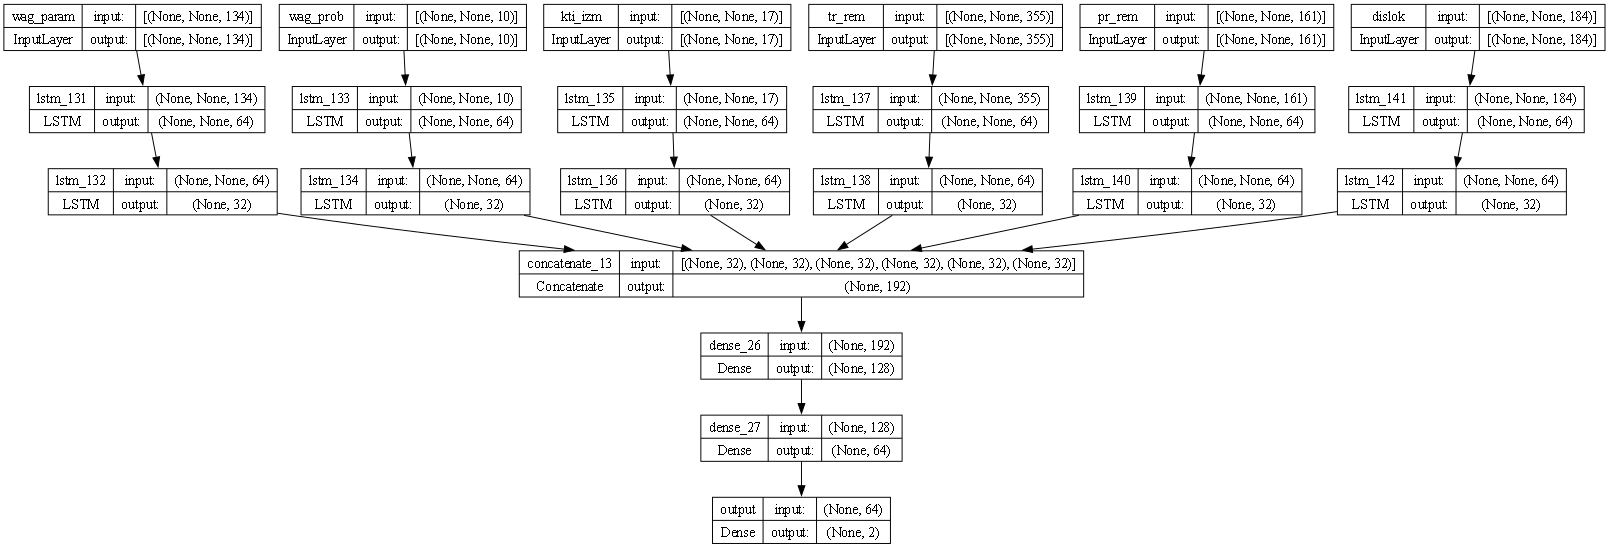

In [199]:
#@title Обзор сети
shapes = {
      'wag_param':(None, 134),
      'wag_prob': (None, 10),
      'kti_izm': (None, 17),
      'tr_rem': (None, 355),
      'pr_rem': (None, 161),
      'dislok': (None, 184)
}
model = get_model(shapes, 'wagonwizards')
print(model.summary())
utils.plot_model(model, show_shapes=True, dpi=70)

In [200]:
#@title Компилируем модель
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [ ]:
#@title Обучение модели
history = model.fit(x_train, y_train,
    epochs=500, batch_size=32,
    validation_data=(x_valid, y_valid),
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.5, patience=5, min_lr=0.00000001),
        EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
    ]
)

Epoch 1/500
23/23 [==============================] - 647s 28s/step - loss: 0.0403 - val_loss: 0.0190 - lr: 0.0010
Epoch 2/500
 2/23 [=>............................] - ETA: 9:48 - loss: 0.0000e+00 

In [ ]:
# Построение графика функции потерь
plt.figure(figsize=(8, 6))
plt.title('График среднеквадратичесной ошибки')
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Оценка метрики

In [ ]:
from train_1.metrics_f1 import calc_f1_score

target = pd.read_csv(PATH + os.sep + 'target/y_train.csv').convert_dtypes()

# подготовка презсказания. Нужно убрать, когда будут другие данные.
pred_target = target[['wagnum']]                               # номера вагонов для предсказания взяты из имеющегося файла
month_to_predict = pd.to_datetime('2022-12-01')       # дата предсказания
pred_target['current_date'] = month_to_predict                 # месяц, на который нужно предсказание
pred_target['target_month'] = 1                                # заполняю одним числом
pred_target['target_day'] = pred_target['target_month']                 # заполняю тем же числом
target_path = PATH + os.sep + 'prediction/target_predicton.csv'
pred_target.drop_duplicates(subset = 'wagnum').to_csv(target_path, index=False)

# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
true_target_path = PATH + os.sep + 'prediction/target_predicton_true.csv'
target.drop_duplicates(subset = 'wagnum').to_csv(true_target_path, index=False)

# оценим насколько хорошо удалось предсказать выбытие вагонов  по месяцу и по 10 дням
calc_f1_score( true_target_path, target_path,)